In [1]:
from pathlib import Path
from datetime import datetime
from dateutil import tz

import numpy as np
from datetime import datetime
import xarray as xr
from xarray.backends import NetCDF4DataStore
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from matplotlib.colors import Normalize
from cartopy import crs as ccrs
from metpy.plots import USCOUNTIES, ctables
import metpy.calc as mpcalc
from scipy.ndimage import gaussian_filter

## Model Reflectivity

In [4]:
%%capture

# Define area to plot
BOTTOM_LAT = 23
TOP_LAT = 40
LEFT_LON = -97
RIGHT_LON = -70

# Model Endpoints 
hrrr = 'https://nomads.ncep.noaa.gov/dods/hrrr/hrrr20210705/hrrr_sfc.t15z'
arw = 'https://nomads.ncep.noaa.gov/dods/hiresw/hiresw20200430/hiresw_conusarw_12z'
nbm = 'https://nomads.ncep.noaa.gov/dods/blend/blend20200417/blend_1hr_22z'
rap = 'https://nomads.ncep.noaa.gov/dods/rap/rap20200503/rap_21z'
gfs = 'https://nomads.ncep.noaa.gov/dods/gfs_0p25/gfs20200429/gfs_0p25_18z'

base_url = hrrr

ds = xr.open_dataset(base_url, decode_times=True)

# Take lat and lon slices
LAT_SLICE = slice(BOTTOM_LAT, TOP_LAT)

if base_url == gfs:
    LON_SLICE = slice(360 + LEFT_LON, 360 + RIGHT_LON)
else:
    LON_SLICE = slice(LEFT_LON, RIGHT_LON)
    
# Extract all lats, lons, and meteorological datasets to plot
lats = ds.lat.sel(lat=LAT_SLICE).values

if base_url == gfs:
    lons = ds.lon.sel(lon=LON_SLICE).values
else:
    lons = 360 + ds.lon.sel(lon=LON_SLICE).values

# Capture model variable we want to plot
data = ds.refcclm

## Time Conversion from UTC to Eastern Time

In [5]:
def convert_datetime_from_nomads_to_local(string):
    from_zone = tz.gettz('UTC')
    to_zone = tz.gettz('America/New_York')
    utc_time = datetime.strptime(string, '%Y-%m-%dT%H:%M:%S').replace(tzinfo=from_zone)
    eastern = utc_time.astimezone(to_zone)
    date_time = datetime.strftime(eastern, '%a, %b %d, %Y %I:%M %p').lstrip('0').replace(' 0', ' ')
    return date_time

## Setup Basemap
Build this outside of the forecast loop since these features stay the same

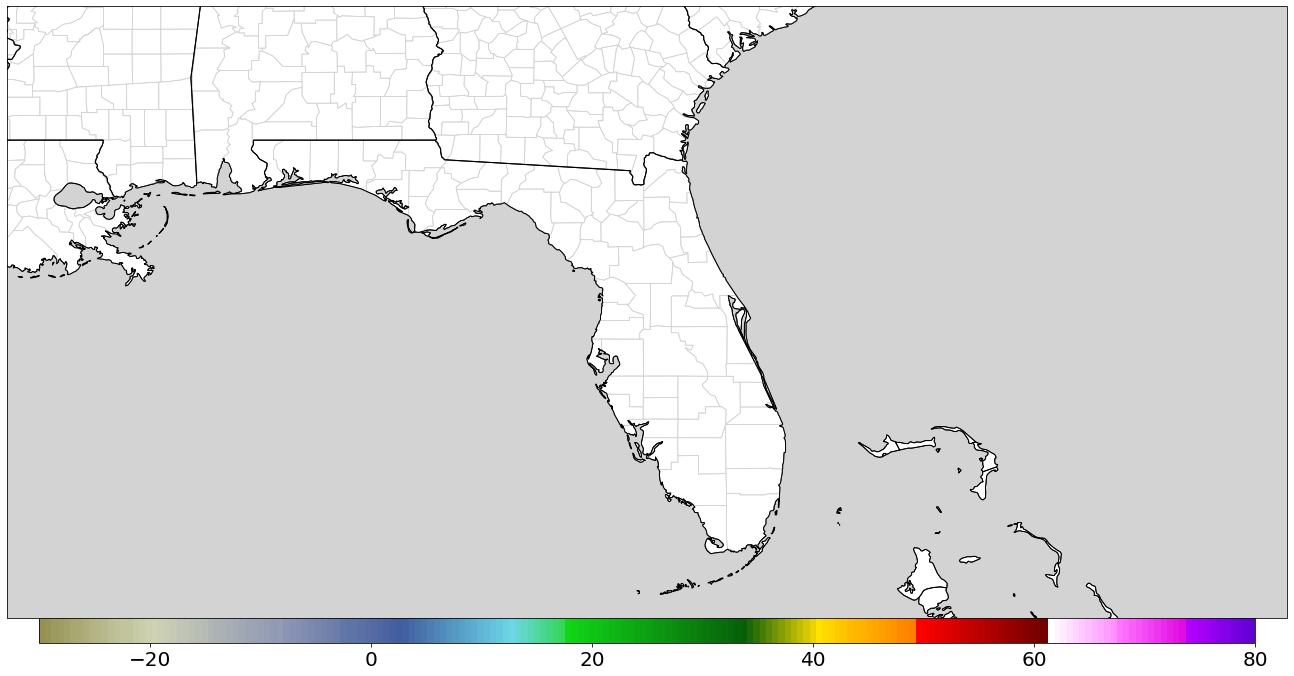

In [6]:
#%%capture
# Setup matplotlib figure
fig = plt.figure(figsize=(1280/72, 720/72))
ax = fig.add_axes([0, 0, 1, 1], projection=ccrs.PlateCarree())

# Add state lines, coastlines, map extent
ax.add_feature(cfeature.OCEAN.with_scale('10m'), color='lightgray')
ax.add_feature(cfeature.COASTLINE.with_scale('10m'), linewidth=0.75)
ax.add_feature(USCOUNTIES.with_scale('20m'), edgecolor='lightgray', zorder=1, linewidth=0.75)
ax.add_feature(cfeature.STATES.with_scale('10m'), linewidth=1.00)
#ax.set_extent([-89, -75, 23.5, 38]) #SE CONUS
#ax.set_extent([-89, -83, 28.5, 32.5]) #Florida Panhandle
#ax.set_extent([-82, -80, 24.5, 29.5]) #South Florida
ax.set_extent([-84, -80, 24.2, 32.9]) #Florida
ax.set_adjustable('datalim')

norm, cmap = ctables.registry.get_with_steps('NWSStormClearReflectivity', 20, 5)
#cm = plt.cm.get_cmap('gist_ncar')
xy = range(80)
z = xy
sc = plt.scatter(xy, xy, c=z, s=35, cmap=cmap, norm=Normalize(-30, 80))
cbar = plt.colorbar(sc, orientation='horizontal', pad=0, aspect=50, shrink=0.95)
cbar.ax.tick_params(labelsize=20)

## Model Time Series
Function to plot model data and manage text/contours so they're removed before the next timestep is plotted

In [7]:
contour_fills = []

def init():
    global contour_fills
    if len(contour_fills) > 0:
        for contour in contour_fills[0].collections:
            contour.remove()
        contour_fills = []

def plot_model_data(time_step):
    global contour_fills
    
    if len(contour_fills) > 0:
        for contour in contour_fills[0].collections:
            contour.remove()
        contour_fills = []
        
    if len(ax.texts) > 0:
        for txt in ax.texts:
            txt.set_visible(False)
            
    refl = data.isel(time=time_step)
    local_time = convert_datetime_from_nomads_to_local(str(refl.time.values).split('.')[0])
    refl = refl.metpy.sel(lat=LAT_SLICE, lon=LON_SLICE).squeeze().metpy.unit_array
    
    reflectivity_values = np.arange(20, 80, 5)
    contour_fill = ax.contourf(lons, lats, refl, reflectivity_values,
                           cmap=cmap, norm=Normalize(-30, 80), transform=ccrs.PlateCarree())
    contour_fills.append(contour_fill)
    
    text = ax.text(0.02, 0.95, s=f'Model Simulated Radar\n{local_time}',
                   fontsize=36, fontweight='bold', fontname='Arial',
                   color='white', bbox={'facecolor': 'navy', 'alpha': 1.0, 'edgecolor': 'none'},
                   transform=ax.transAxes, zorder=10, va='top')

## Animation function
Reflectivity is often not available at t=0, so initialize at t=1

In [8]:
def animate(frame, start_hour):
    frame += start_hour
    plot_model_data(frame + 1)

## Display JS Animator within Jupyter Lab
Execute the code that builds the animation

In [9]:
plt.rcParams['animation.html'] = 'jshtml'

start_hour = 3
forecast_hours = 8

anim = FuncAnimation(fig, animate, 
                     frames=forecast_hours, 
                     init_func=init, 
                     interval=300, 
                     fargs=(start_hour, ))
anim

## Write MP4 and GIF

In [10]:
graphics_dir = '../..' / Path('.') / 'graphics' / 'models'

#anim.save(f'{graphics_dir}/reflectivity_hrrr.mp4', writer='ffmpeg', fps=3)
anim.save(f'{graphics_dir}/reflectivity_hrrr.gif', writer='pillow', fps=2)